In [72]:
import sys  
sys.path.insert(0, './codes')

from pade_func import pade_analytic_continuation


#### NOTE: hbar and k_B are equal to 1

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import holoviews as hv
import pandas as pd
import xarray as xr

In [60]:
def density_of_states_behte_non_int (omega, D):
    '''
    density of states of a Bethe lattice with infinite connectivity 
    (from the analytical expression of the non interacting GF)

    input:      omega       real frequency/energy 
                D           bandwidth, the density of states is non zero for |omega|<D

    output:     rho(omega)  densiy of states, rho(w)=2*sqrt(D^2-w^2)/pi*D^2
    '''

    return 2*np.sqrt(D**2-omega**2)/np.pi*D**2

def get_Gloc(rho,omega_n,eps):
    '''
    get local interacting green's function
    input:    rho           vector with density of states evaluated at all the energy steps of the integral
              omega_n       vector with matzubara frequencies form O to N_matz_freq
              eps           values of energies of the integration = eps=np.linspace(-D,D,len(omega_n))
    '''
    sigma_imp=0.

    Gloc=np.zeros(len(omega_n))+0*1j
    d_eps=(eps[-1]-eps[0])/len(eps)

    for i in range(len(eps)):
        Gloc += rho[i]/(omega_n-eps[i]-sigma_imp)*d_eps
    return Gloc



In [61]:
N_cutoff = 500
##### TODO:  CHECK THE CUTOFF FOR EVALUATING THE SUM IN THE FOURIER TRANSFORM  ############

def fourier_trans_to_imag_time(func, beta, tau):
    '''
    Fourier transform of a function G(i*omega_n) where i*omega_n are Matzubara frequencies
    (needed to perform the Iterative Perturbation Theory Step)
    
    input:      func        G(i*omega_n): function of i*omega (Matzubara frequencies)
                beta        inverse temperature
                tau         imaginary time        

    output:     G(tau)      function of the imaginary time (tau), G(tau)=(1/beta)* sum_(w_n)  (e^i*w_n*tau)*G(i*omega_n)
    '''

    nn = np.linspace(start=0, stop=N_cutoff, num=N_cutoff, dtype=int)
    matz_frequencies = np.pi*(1/beta) * (2*nn + 1)
    
    G_iw = func
    exponential_iw = np.exp(-1j * matz_frequencies*tau)

    return  np.sum(exponential_iw*G_iw) / beta

In [62]:
########### TODO: find limits of integration for the integral in time!!!  
time_integral_steps=500

def iterative_perturbation_theory_impurity_solver(impurity_non_int_greens_func, iomega, U, beta):
    '''
    finds the self energy of the auxiliary Anderson impurtity model Sigma_imp
    from this it evaluates also the interacting Green's function of the auxiliary system (G coursive)

    input:      impurity_non_int_greens_func        G_0 (iomega) coursive: non interacting Green's function of the auxiliary system
                                                                           encoded in step (3) and evaluated on Matzubara frequency
                iomega                              Matzubara frequency i*omega_n
                U                                   impurity interaction
                beta                                inverse temperature  

    output:     impurity_self_energy(iomega)        self energy of the auxiliary system    Sigma_imp(iw)=U/2 + U^2 * int_0^beta d(tau) (e^i*w_n*tau) * G_0^shifted(tau)^3
                                                                                           knowing G_0^shifted(iw)= (G_0(iw)^-1  - U/2)^-1     where all the G are coursive
                impurity_int_greens_func(iomega)    interacting GF of the auxiliary system   G(iw) = (  G_0(iw)^-1 - Sigma_imp(iw)  )^-1          where all the G are coursive

    note: this fucntion uses the function fourier_trans_to_imag_time() to convert G_0^shifted(iw) coursive in imaginary time
    '''

    # I calculate G_0_shifted(iw) as a function of iomega
    shifted_impurity_non_int_greens_func = 1 / ( (1/impurity_non_int_greens_func) - U*0.5 )

    # I calculate the fourier transform G_0_shifted(tau)
    tau = np.linspace(start=0, stop=beta, num=time_integral_steps)
    G_0_shifted_tau = fourier_trans_to_imag_time(shifted_impurity_non_int_greens_func, beta, tau)
    exponential_tau = np.exp(1j * iomega*tau)

    # I calculate the integral
    integral = np.sum(exponential_tau * G_0_shifted_tau**3)

    # I get Sigma_imp and the interacting GF of the impurity
    Sigma_imp = U*0.5 + U**2  * integral

    G_0_iw = impurity_non_int_greens_func
    G_imp = 1 / ( 1/G_0_iw + Sigma_imp )
    return Sigma_imp, G_imp

## Test of analytic continuation for the Bethe lattice 

/var/folders/p9/vmfpstws7vd67rl49m49vhxr0000gq/T/ipykernel_89239/2877449616.py:12: RuntimeWarning: invalid value encountered in sqrt
  return 2*np.sqrt(D**2-omega**2)/np.pi*D**2


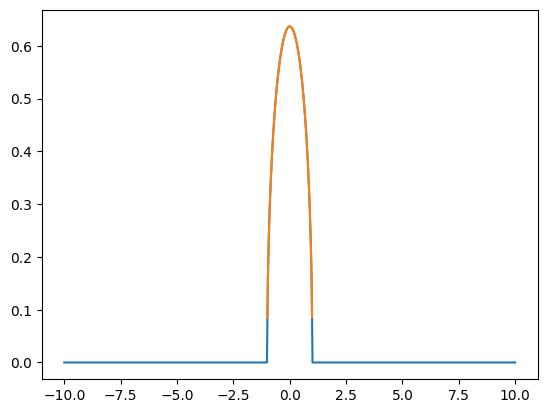

In [66]:
beta=20
D = 1.0
N_iomega=500
U = 1
epsylon = 0.01

nn = np.linspace(start=-(N_iomega-1)/2, stop=(N_iomega-1)/2, num=N_iomega, dtype=int)
iomega = 1j*np.pi*(2*nn+1)/beta

N_energy = 1000
emin = -10.0
emax = 10.0
energy = np.linspace(emin, emax, N_energy)


# analytic formula non int gf bethe
gf_non_int=2/(D**2) * (energy - np.sqrt(energy**2-D**2, dtype=complex))
plt.plot(energy, -gf_non_int.imag/np.pi)

# analytic formula of the density
plt.plot(energy, density_of_states_behte_non_int(energy,D))

# gf on matzubara freq
gf_non_int_matz=2/(D**2) * (iomega - np.sqrt(iomega**2-D**2, dtype=complex))
gf_non_int_real_freq = pade_analytic_continuation(wn=iomega.imag, gf=gf_non_int_matz.reshape((1,N_iomega)))[0]

## DMFT cycle

In [75]:
N_iter_max = 10
# step 1: set Sigma_loc
Sigma_loc = np.zeros(N_iomega)

Gloc_list = []
Gimp0_list = []
Gimp_list = []


for n_iter in range(N_iter_max):
    # step 2: get local GF

    # ---> define the energies where to integrate:
    omega_n=np.pi/beta*(2*np.array(range(0,N_iomega))+1)
    eps=np.linspace(-D,D,len(omega_n))
    rho = density_of_states_behte_non_int(eps,D)

    G_loc=get_Gloc(rho=rho,omega_n=1j*omega_n, eps=eps)
    Gloc_list.append(G_loc)

    # step 3: obtain the impurity GF
    Gimp_non_int= 1/( (1/G_loc) + Sigma_loc )
    Gimp0_list.append(Gimp_non_int)

    # step 4: solve impurity model
    Sigma_imp, G_imp = iterative_perturbation_theory_impurity_solver(impurity_non_int_greens_func=Gimp_non_int, iomega=1j*omega_n, U=U, beta=beta)
    Gimp_list.append(G_imp)

    # step 5:
    if np.sum(np.abs(G_loc - G_imp))<epsylon:
        print('I reached convergence!', )
        break
    else:
        print('I completed iteration number', n_iter, 'distance', np.sum(np.abs(G_loc - G_imp)))
        # and I start again
        # step 1: set Sigma_loc
        Sigma_loc = Sigma_imp

I completed iteration number 0 distance 5.038326518258231
I completed iteration number 1 distance 6.08918804624849
I completed iteration number 2 distance 5.73692879662857
I completed iteration number 3 distance 6.080336806541381
I completed iteration number 4 distance 6.060326544436201
I completed iteration number 5 distance 6.007290672853733
I completed iteration number 6 distance 6.046143142980369
I completed iteration number 7 distance 6.0204676820689285
I completed iteration number 8 distance 6.033491347867599
I completed iteration number 9 distance 6.027997783400838


(-2.0, 2.0)

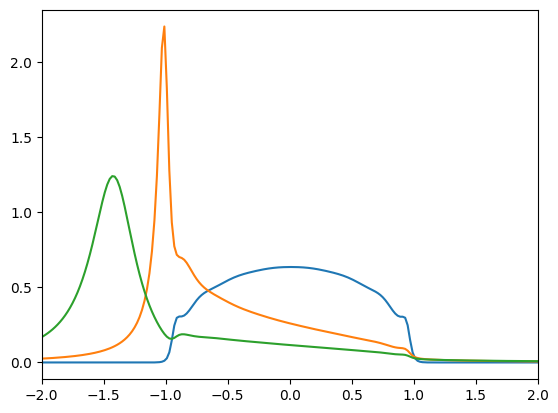

In [71]:
#local interacting
gf_non_int_real_freq = pade_analytic_continuation(wn=omega_n, nw=len(omega_n), gf=G_loc.reshape((1,N_iomega)))[0]
plt.plot(energy, -gf_non_int_real_freq.imag/np.pi)

# imputity non interacting
gf_non_int_real_freq = pade_analytic_continuation(wn=omega_n, nw=len(omega_n), gf=Gimp_non_int.reshape((1,N_iomega)))[0]
plt.plot(energy, -gf_non_int_real_freq.imag/np.pi)

# imputity interacting
gf_non_int_real_freq = pade_analytic_continuation(wn=omega_n, nw=len(omega_n), gf=G_imp.reshape((1,N_iomega)))[0]
plt.plot(energy, -gf_non_int_real_freq.imag/np.pi)
plt.xlim(-2,2)
plt.xlim(-2,2)

In [77]:
(-np.array(Gloc_list).imag/np.pi).flatten()



array([0.54333241, 0.40294551, 0.30886294, ..., 0.00203232, 0.00202824,
       0.00202418])

In [76]:
plts = []
df = pd.DataFrame( data={'n_iter':          range(N_iter_max),
                         'energy':          energy 
                        '-Gloc.imag/pi':   (-np.array(Gloc_list).imag/np.pi).flatten(), 
                        '-Gimp_0.imag/pi': (-np.array(Gimp0_list).imag/np.pi).flatten(),
                        '-Gimp.imag/pi':   (-np.array(Gimp0_list).imag/np.pi).flatten()})

df = df.set_index(['n_iter'])
ds=xr.Dataset.from_dataframe(df)
            
plts.append(hv.Dataset(ds['-Gloc.imag/pi']).to(hv.Curve,
                groupby=['n_iter'],dynamic=True).opts(ylim=(-0.2,1),tools=['hover','yzoom_in']))
        
hv.Layout([plt.opts(tools=['hover','yzoom_in'],height=400,width=400) for plt in plts]).cols(2)

ValueError: Per-column arrays must each be 1-dimensional

In [ ]:
        
        plts = []

        df = pd.DataFrame( data={'Freq(GHz)':     data.freq,
                                 'Magn_curr(A)':  data.field, 
                                 'Modulus(dB)':   20*np.log10(np.abs(data.derivative)),
                                 'Phase(rad)':    np.angle(data.derivative)
                                 })

        df = df.set_index(['Freq(GHz)', 'Magn_curr(A)'])
        ds=xr.Dataset.from_dataframe(df)
        
        plts.append(hv.Dataset(ds['Modulus(dB)']).to(hv.Curve,
                       groupby=['Freq(GHz)'],dynamic=True).opts(ylim=(-120.0,10.0),tools=['hover','yzoom_in']))
        plts.append(hv.Dataset(ds['Phase(rad)']).to(hv.Curve,
                       groupby=['Freq(GHz)'],dynamic=True).opts(ylim=(-np.pi,np.pi),tools=['hover','yzoom_in']))
        
        return hv.Layout([plt.opts(tools=['hover','yzoom_in'],height=400,width=400) for plt in plts]).cols(2)